In [41]:
import os
from sys import path
# read yaml config file
import yaml
with open("../config/main.yaml", 'r') as stream:
    config = yaml.safe_load(stream)
CODE_PATH = config['paths']['CODE_PATH']
WAVE_CLUS_PATH = config['paths']['WAVE_CLUS_PATH']
DATA_PATH =  config['paths']['DATA_PATH']
OUTPUT_FOLDER = config['paths']['OUTPUT_FOLDER']
path.insert(0, CODE_PATH) # adds code folder to path


# Preprrocessing Config
with open("../config/preprocess/preprocess.yaml", 'r') as stream:
    PPC = yaml.safe_load(stream)
MIN_FREQ = PPC['bandpass']['low_cutoff']
MAX_FREQ = PPC['bandpass']['high_cutoff']

from custom_recording_extractors import NSXRecordingExtractor
from aux_functions import same_probe_collisions, create_waveform_extractors_by_channel, \
    plot_sorting_results, load_waveforms_extractors 
import numpy as np
from pathlib import Path
from shutil import rmtree

import numpy as np
import matplotlib.pylab as plt
import scipy.signal

import spikeinterface as si
import preprocessing_functions as pf
import spikeinterface.preprocessing as sp
import spikeinterface.sorters as ss
import spikeinterface.extractors as se
import spikeinterface.widgets as sw
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120 #better matplotlib in jupyter
mpl.rcParams['font.size'] = 10 #better matplotlib in jupyter
ss.WaveClusSorter.set_waveclus_path(WAVE_CLUS_PATH)

Setting WAVECLUS_PATH environment variable for subprocess calls to: /Users/masoudkhani/Documents/Programming/Internship 2023/wave_clus


# Reading the data

In [42]:
# Define the channels to extract data from
channels = [2042]

# Create a recording extractor object for the specified channels and data path
recording = NSXRecordingExtractor(channels=channels, folder_path=DATA_PATH)

# Extract the traces for the first segment and the first channel
data = recording.get_traces(segment_index=0)[:, 0]

# Get the sampling frequency of the recording
fs = recording.get_sampling_frequency()

# Compute the power spectrum using Welch's method
f, p = scipy.signal.welch(data, fs=fs)

# sampel output
fs, data, recording

(30000,
 array([   0,    0,    0, ...,  -97, -104,  -95], dtype=int16),
 NSXRecordingExtractor: 1 channels - 1 segments - 30.0kHz - 2110.083s)

# Plot the data vs power spectrum

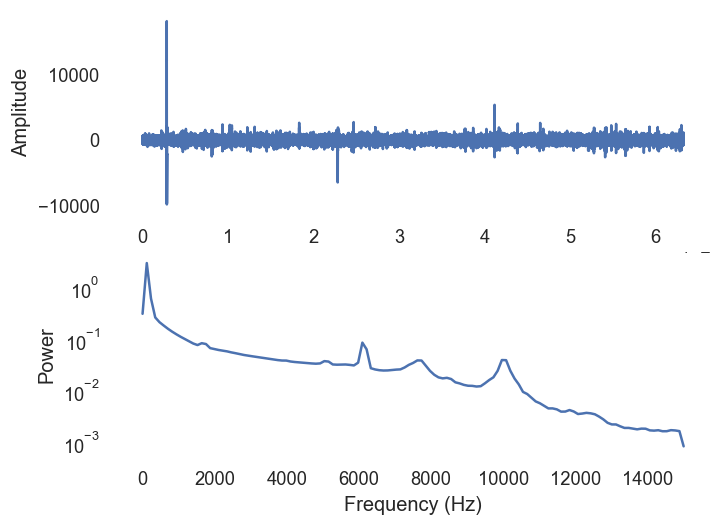

In [43]:
# Plot the data
plt.subplot(2, 1, 1)
plt.plot(data)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

# Plot the power spectrum
plt.subplot(2, 1, 2)
plt.semilogy(f, p)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

plt.show()

-------
# Calculate the notches
-------


In [44]:
#apply calculed notches
recording_notched = pf.filter_freq_peaks(recording, load_mat_notches=False)

-------
# BAND PASS FILTERING
-------

In [45]:
recording_bp = sp.BandpassFilterRecording(recording_notched, freq_min=MIN_FREQ, freq_max=MAX_FREQ, filter_order=2)
recording_bp

BandpassFilterRecording: 1 channels - 1 segments - 30.0kHz - 2110.083s

------
# Whiten the data
------


In [46]:
recording_whiten = sp.whiten(recording_bp)

-------
# plot timeseries and power spectrum
-------

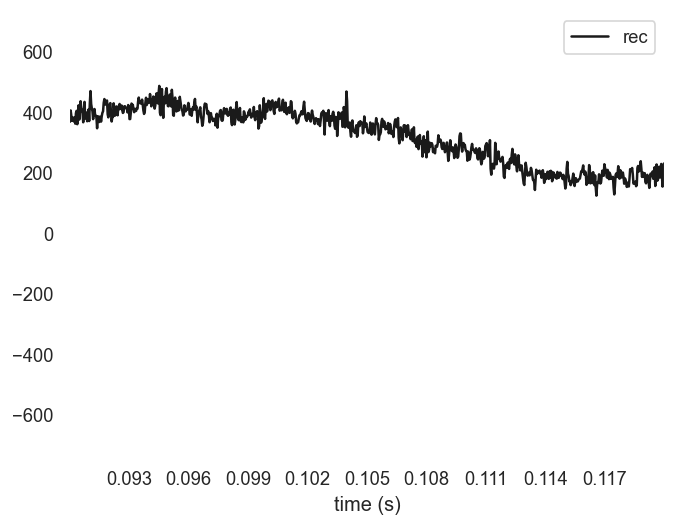

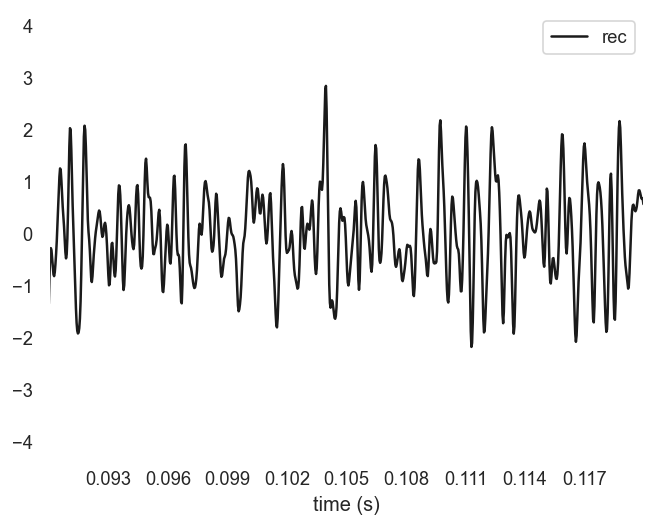

In [71]:

sw.plot_timeseries(recording_notched, time_range=(0.0090*10, 0.0120*10))
sw.plot_timeseries(recording_whiten, time_range=(0.0090*10, 0.0120*10))


# Remove Artifacts Based on Euclidean Distance

In [69]:
from spikeinterface import extractors
from scipy.spatial import distance
import numpy as np

def remove_artifacts_spikeinterface(recording, sorting, unit_id, window_size, threshold=0.1):
    """
    Remove artifacts based on euclidean distance from SpikeInterface recording

    Parameters
    ----------
    recording : spikeinterface.RecordingExtractor
        The recording extractor with the spike data.
    sorting : spikeinterface.SortingExtractor
        The sorting extractor with the spike sorting data.
    unit_id : int
        The ID of the unit to check for multiple events.
    window_size : int
        The size of the window to divide the entire data into.
    threshold : float, optional
        The number of standard deviations above the mean to set the threshold for removing artifacts.
        Default is 0.1.

    Returns
    -------
    filtered_data : list of np.array
        A list of filtered data with artifacts removed for each window.
    """
    # Get the total number of frames
    total_frames = recording.get_num_frames()

    # Create a list to hold the filtered data for each window
    filtered_data = []

    for start_frame in range(0, total_frames, window_size):
        end_frame = min(start_frame + window_size, total_frames)

        # Get the spike times for the specified unit
        spike_times = sorting.get_unit_spike_train(unit_id)

        # Check if there are multiple events in the time window
        events_in_window = np.logical_and(spike_times >= start_frame, spike_times < end_frame)

        if np.sum(events_in_window) <= 1:
            print("There is one or no event in the window from frame {} to {} for unit {}.".format(start_frame, end_frame, unit_id))
            continue

        # Get the data in the given time frame
        data = recording.get_traces(start_frame=start_frame, end_frame=end_frame)

        # Calculate the euclidean distance
        euclidean_distance = np.sqrt(np.sum(np.square(data), axis=1))

        # Calculate the threshold
        threshold_value = np.mean(euclidean_distance) + threshold * np.std(euclidean_distance)

        # Remove the artifacts
        data = data[euclidean_distance < threshold_value]

        # Append the filtered data to the list
        filtered_data.append(data)

    return filtered_data

-------
# Spike Sorting Algorithms
-----
Algorithm installed in the spikeinterface library:
- herdingspikes
- spykingcircus
- spykingcircus2
- tridesclous
- tridesclous2
- waveclus

In [58]:
sorting_SC = ss.run_sorter("waveclus", recording_whiten, output_folder=OUTPUT_FOLDER)

Traceback (most recent call last):
  File "/Users/masoudkhani/miniforge3/lib/python3.9/site-packages/spikeinterface/sorters/basesorter.py", line 226, in run_from_folder
    SorterClass._run_from_folder(sorter_output_folder, sorter_params, verbose)
  File "/Users/masoudkhani/miniforge3/lib/python3.9/site-packages/spikeinterface/sorters/external/waveclus.py", line 213, in _run_from_folder
    raise Exception('waveclus returned a non-zero exit code')
Exception: waveclus returned a non-zero exit code



SpikeSortingError: Spike sorting failed. You can inspect the runtime trace in /Users/masoudkhani/Documents/Programming/Internship 2023/OUTPUT/spikeinterface_log.json

# WaveClus

In [48]:
ss.run_sorter_by_property(sorter_name='waveclus',recording=recording_whiten, detect_threshold=4.5, detect_sign=-1, enable_detect_filter=False, enable_sort_filter=False, grouping_property='channel', working_folder=OUTPUT_FOLDER/Path('sortings'),mode_if_folder_exists='overwrite',engine='joblib')
# Then rename auxiliary waveclus files and allow manual curation using temperature plot
# and remove the copy of the filtered recording used by wave_clus
for ch in recording_whiten.get_channel_ids():
    resfolder = OUTPUT_FOLDER/Path('sortings')/Path(str(ch))/Path('waveclus/sorter_output')
    #reducing size and renaming to help waveclus manual curation of results
    os.rename(resfolder/Path('data_raw1.dg_01.lab'),resfolder/Path('data_results.dg_01.lab'))
    os.rename(resfolder/Path('data_raw1.dg_01'),resfolder/Path('data_results.dg_01'))
    os.remove(resfolder/Path('raw1.h5'))

/Users/masoudkhani/miniforge3/lib/python3.9/site-packages/spikemetrics/metrics.py:15: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


SpikeSortingError: Spike sorting failed. You can inspect the runtime trace in spikeinterface_log.json

# Mountain Sort

In [49]:
import mountainsort5 as ms5

# use scheme 1
sorting = ms5.sorting_scheme1(
    recording=recording_whiten,
    sorting_parameters=ms5.Scheme1SortingParameters()
)

Number of channels: 1
Number of timepoints: 63302482
Sampling frequency: 30000 Hz
Channel 0: [48.  0.]
Loading traces
Detecting spikes

Adjacency for detect spikes with channel radius None
[[0]]

m = 0 (nbhd size: 1)
Extracting 15226 snippets
Clustering snippets


ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'